In [209]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import matplotlib
import pyrosetta as pr
pr.init("-mute core basic protocols")
matplotlib.rcParams["figure.figsize"] = (15,15)

PyRosetta-4 2019 [Rosetta PyRosetta4.Release.python37.linux 2019.45+release.fc8ab401178f6f099884fd5a39597b1a9cac8db2 2019-11-05T15:46:43] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [210]:
matplotlib.rcParams["figure.figsize"] = (10,10)

In [211]:
dirname = ""
protein_names = [x.split(".")[0] for x in os.listdir(dirname + "contacts")]


def show_matrix(protein,mask_short=False,mask_middle=False):
        n = max([
            len(protein.sequence), 
            int(protein.contacts["i"].max()), 
            int(protein.contacts["j"].max()), 
            int(protein.xl_sulfo["i"].max()),
            int(protein.xl_sulfo["j"].max()),
            int(protein.xl_photoAA["i"].max()),
            int(protein.xl_photoAA["j"].max()),
        ])
        
        im = np.zeros((n, n))
        ind = protein.contacts[["i", "j"]].values.astype(np.int32) - 1
        values = protein.contacts["p"].values
        im[ind[:,0],[ind[:,1]]] = values
        im[ind[:,1],[ind[:,0]]] = values
        
        if mask_short:
            print(ind.shape)
            too_short = ((ind[:,0] - ind[:,1]) < 12)
            ind_short = ind[too_short,:]
            im[ind_short[:,0],[ind_short[:,1]]] = 0.0
            im[ind_short[:,1],[ind_short[:,0]]] = 0.0
        
        if mask_middle:
            print(ind.shape)
            middle = ((ind[:,0] - ind[:,1]) >= 12)
            middle = ((ind[:,0] - ind[:,1]) <= 23)
            ind_m = ind[middle,:]
            im[ind_m[:,0],[ind_m[:,1]]] = 0.0
            im[ind_m[:,1],[ind_m[:,0]]] = 0.0
        
        
        #sulfo = protein.xl_sulfo[["i", "j"]].values.astype(np.int32) - 1 
        #plt.scatter(sulfo[:,0], sulfo[:,1], color="blue", label="Sulfo")
        #plt.scatter(sulfo[:,1], sulfo[:,0], color="blue")

        photoAA = protein.xl_photoAA[["i", "j"]].values.astype(np.int32) - 1
        plt.scatter(photoAA[:,0], photoAA[:,1], color="red", label="photoAA")
        plt.scatter(photoAA[:,1], photoAA[:,0], color="red")
        plt.legend()
        plt.imshow(im, cmap="gray")
        plt.colorbar()

from sklearn.neighbors import KernelDensity
def show_dist(protein, cutoff_bin=38,density=True):
    sulfo = protein.xl_sulfo[["i", "j"]].values.astype(np.int32) - 1 
    im = p.dist['distogram'][:cutoff_bin,:,:].sum(axis=0)
    if density:
        sulfo_all = np.vstack((sulfo,np.vstack((sulfo[:,1],sulfo[:,0])).T))
        kde = KernelDensity(bandwidth=3, kernel='gaussian').fit(sulfo_all)
        X,Y = np.meshgrid(range(im.shape[0]),range(im.shape[1]))
        xy = np.vstack([Y.ravel(), X.ravel()]).T
        Z = np.exp(kde.score_samples(xy))
        Z = Z.reshape(X.shape)
        levels = np.linspace(0, Z.max(), 15)
        plt.contour(X, Y, Z, levels=levels, cmap=plt.cm.cool)
        plt.colorbar()
    else:
        plt.scatter(sulfo[:,0], sulfo[:,1], color="blue", label="Sulfo")
        plt.scatter(sulfo[:,1], sulfo[:,0], color="blue")
    
     
    
    plt.imshow(im, cmap='gray')
    plt.colorbar()   
    
    
    

In [212]:
class Protein:
    
    def __init__(self, dirname, name):
        self.name = name
        self.native = pr.io.pose_from_pdb(dirname + "pdb/" + name + ".pdb")
        self.sequence = self.native.sequence()
        self.contacts = pd.read_csv(dirname + "contacts/" + name + ".contacts", sep=" ", names=["i", "j", "_1", "_2", "p"])[["i", "j", "p"]]
        self.xl_photoAA = pd.read_csv(dirname + "photoAA_xl/" + name + "_FDR10", sep=" ", names=["i", "j"])
        self.xl_sulfo = pd.read_csv(dirname + "sulfo-SDA_xl/" + name + ".xl", sep=" ", names=["i", "j"])
        self.dist = np.load(dirname + 'distograms/' + name + '.npz')
        print(self.dist)
        
    def __repr__(self):
        return self.name

        

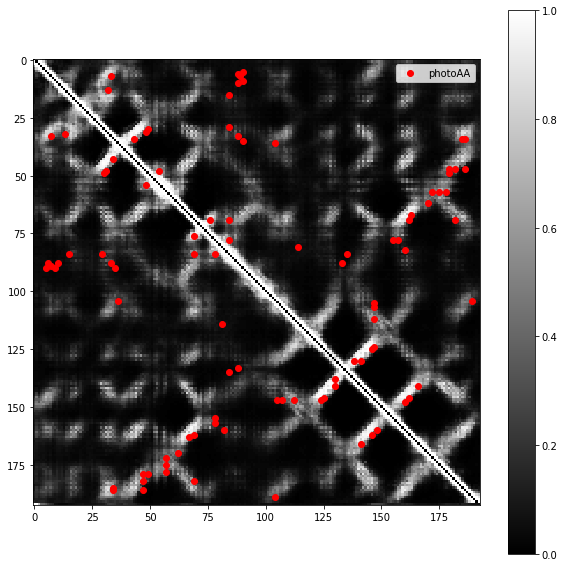

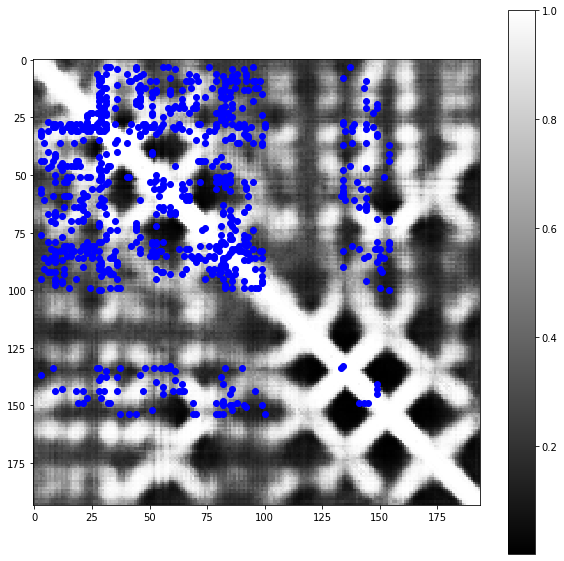

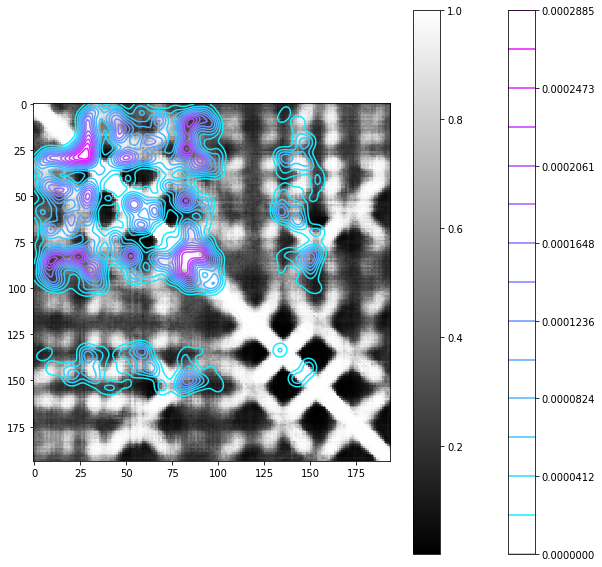

In [94]:
p = Protein(dirname, protein_names[1])
show_matrix(p)
plt.show()
show_dist(p,density=False)
plt.show()
show_dist(p,density=True)

### How accurate are the distogramms actually? => check ground truth on the native

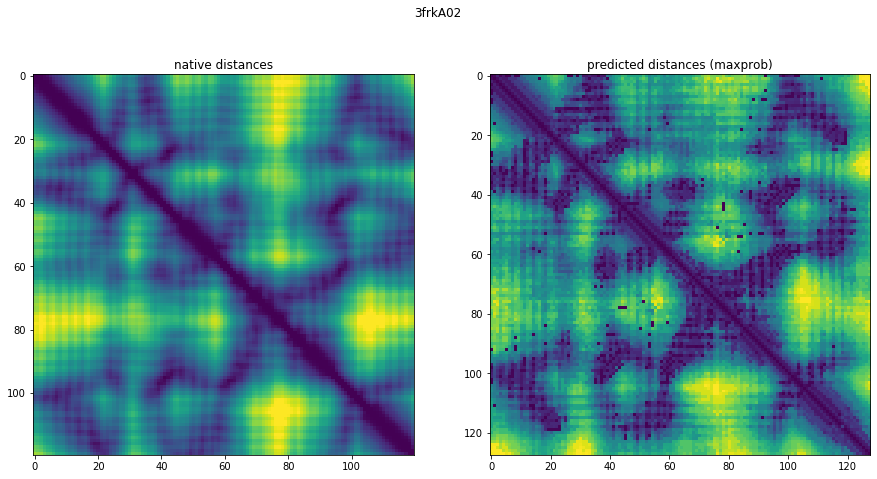

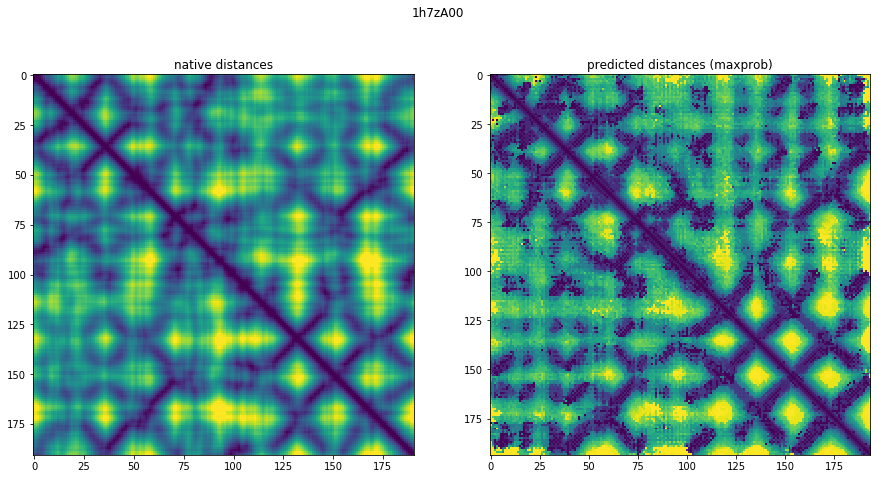

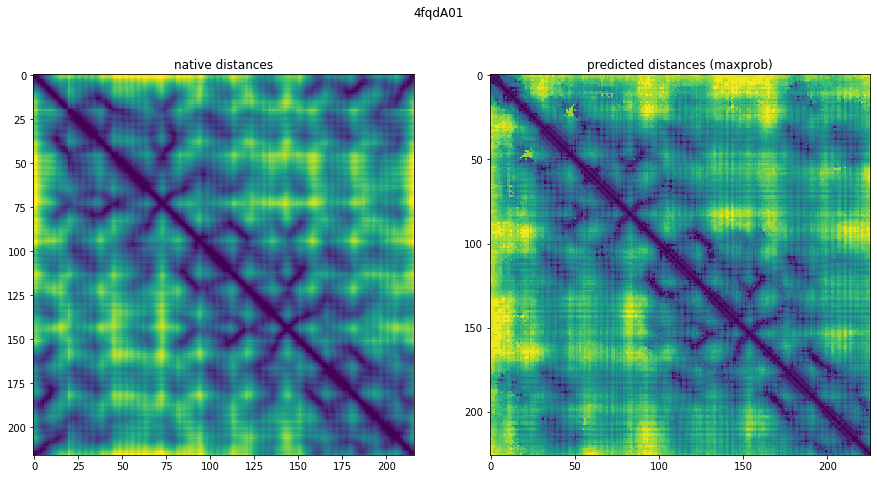

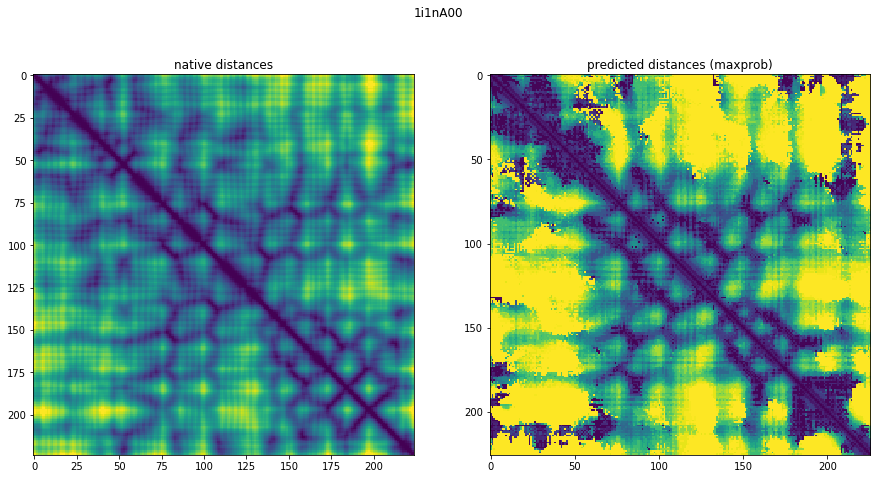

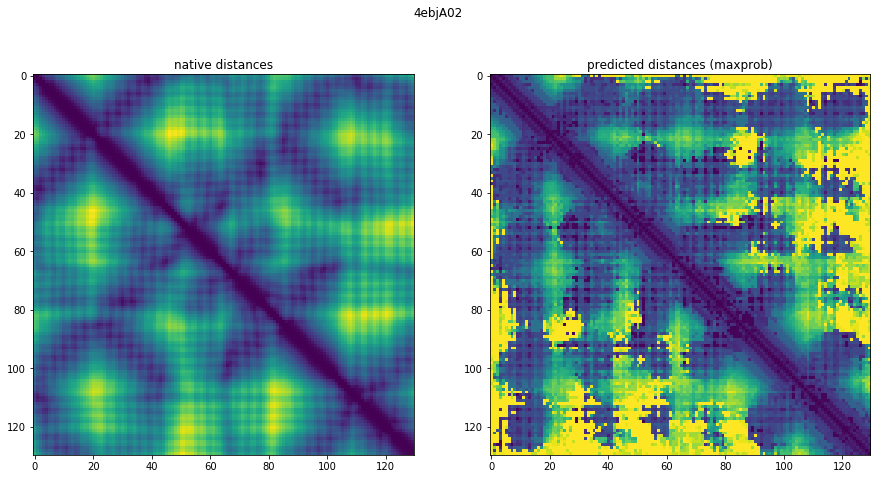

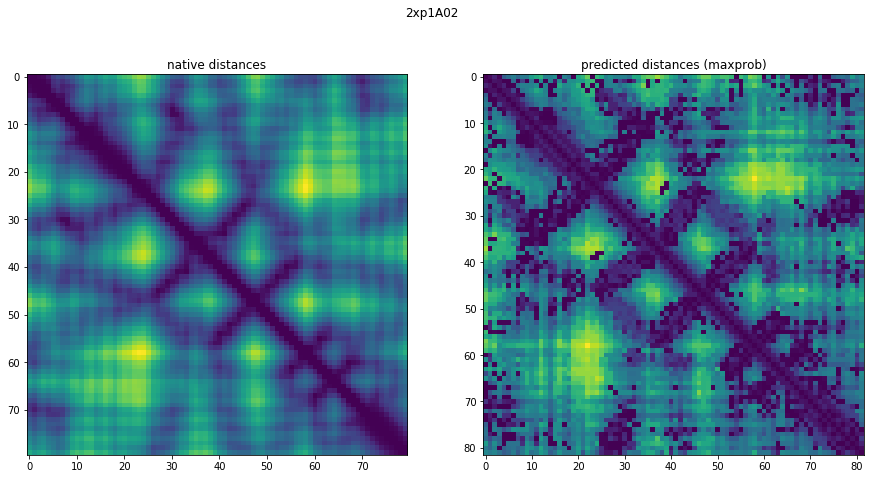

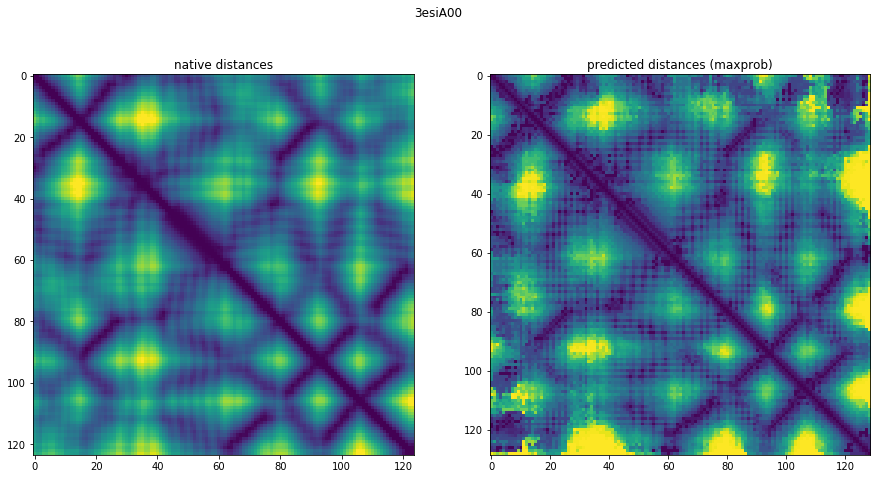

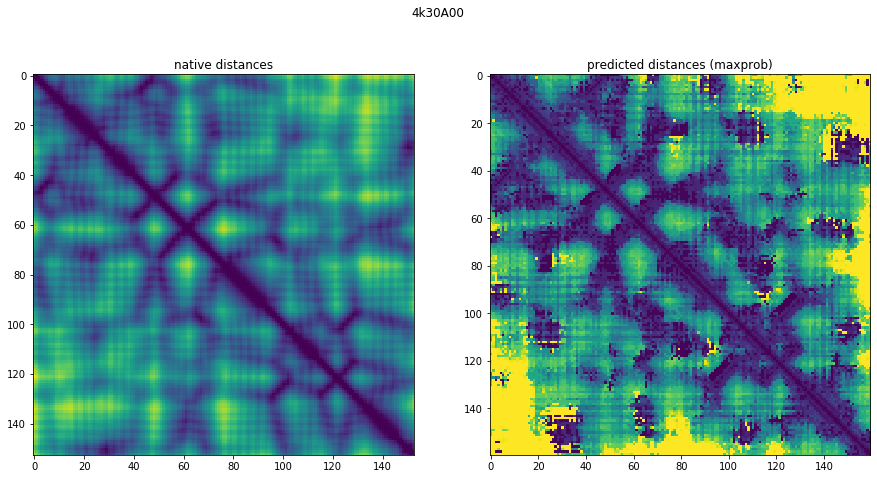

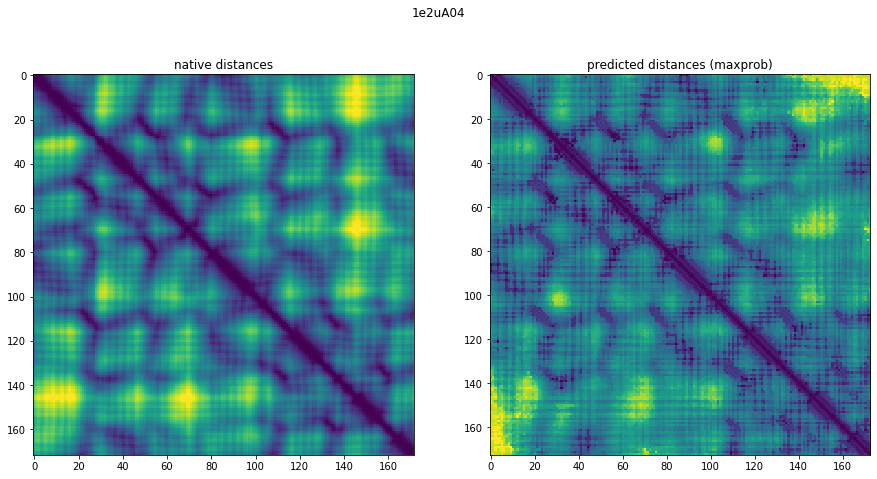

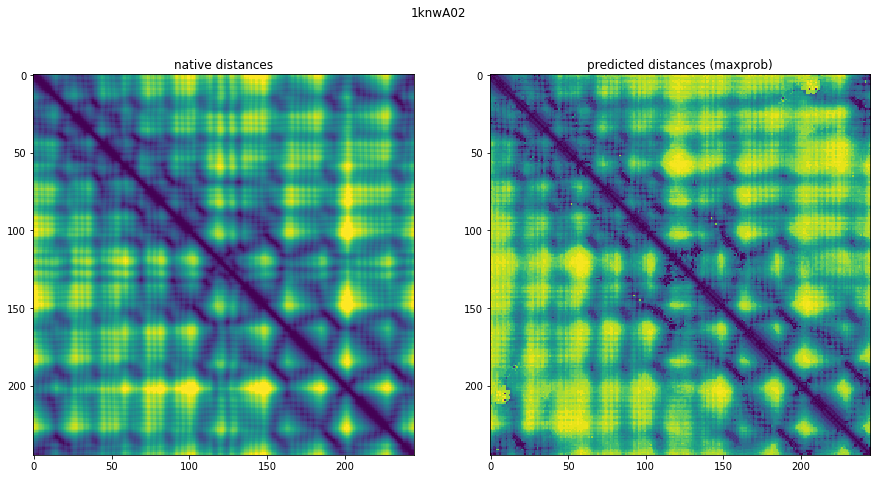

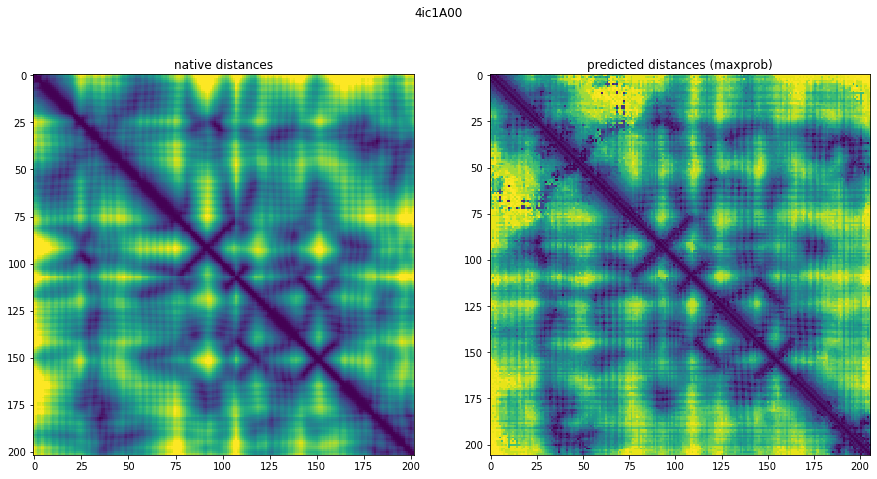

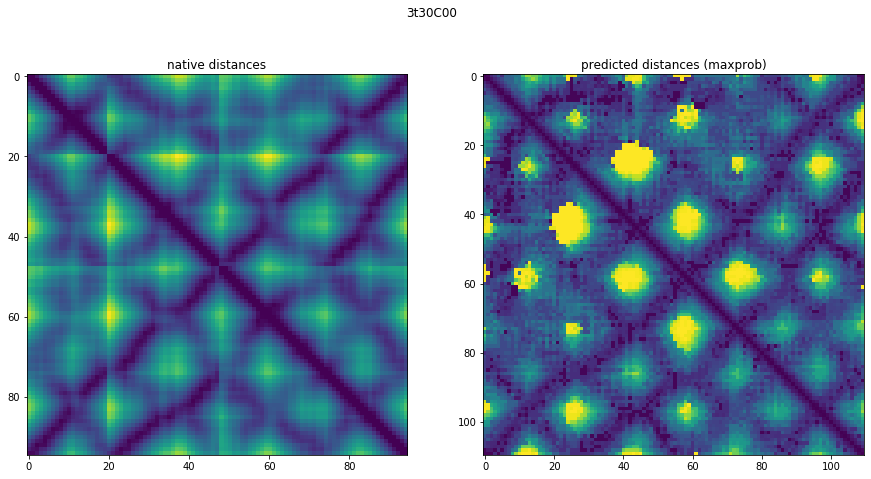

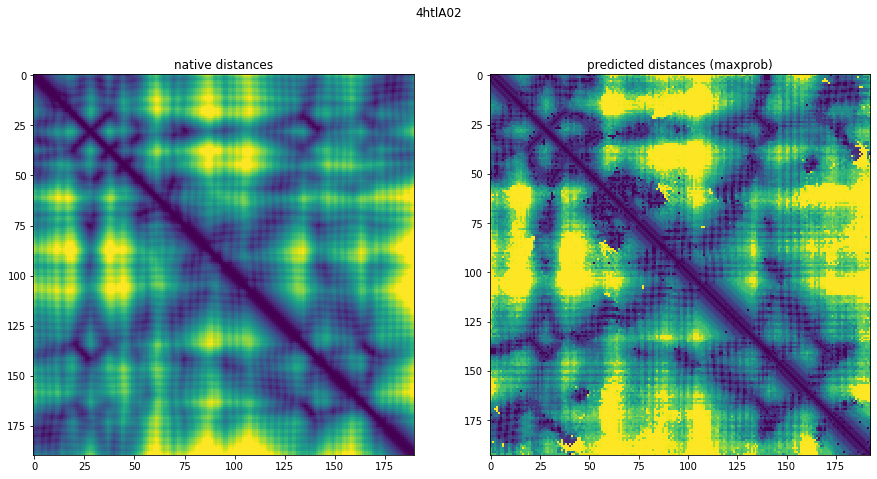

In [237]:
def compare_real_predicted_distance(p):
    pose = p.native
    def xyz(pose,res):
        
        return pose.residue(res).xyz("N")
    
    from itertools import product
    import numpy as np
    residues = p.native.total_residue()
    dist = np.zeros((residues,residues))
    for i, j in product(range(1,residues+1),range(1,residues+1)):
        dist[i-1,j-1] = (xyz(pose,i) - xyz(pose,j)).norm()

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,7.5))    
    fig.suptitle(p.name)
    ax1.imshow(dist.clip(4,42.5))
    ax1.set_title('native distances')
    bins = np.arange(4,42.5,0.5)
    a = np.argmax(p.dist['distogram'],axis=0)
    ax2.imshow(a)
    ax2.set_title('predicted distances (maxprob)')
    plt.show()

for n in protein_names:
    px = Protein(dirname, n)
    compare_real_predicted_distance(px)
    
# weighted mean instead?

### [Observation/Question] Rosetta Format uses splines along one line
=> does it help to smooth out the other dimension?

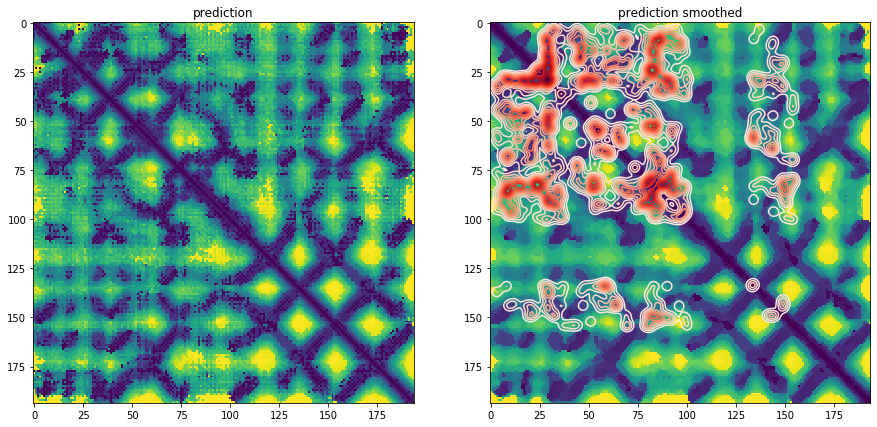

In [220]:
from scipy.ndimage.filters import gaussian_filter as gf
bandwidth = 2

p = Protein(dirname, protein_names[1])
k = gf(p.dist['distogram'], 1)
sulfo = p.xl_sulfo[["i", "j"]].values.astype(np.int32) - 1 
sulfo_all = np.vstack((sulfo,np.vstack((sulfo[:,1],sulfo[:,0])).T))
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian').fit(sulfo_all)

residues =p.dist['distogram'].shape[1] 
X,Y = np.meshgrid(range(residues),range(residues))
xy = np.vstack([Y.ravel(), X.ravel()]).T
Z = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)
levels = np.linspace(0, Z.max(), 15)



# viz
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,7.5))    
ax1.imshow(np.argmax(p.dist['distogram'],axis=0))
ax1.set_title('prediction')
ax2.imshow(np.argmax(k,axis=0))
ax2.set_title('prediction smoothed')
ax2.contour(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
#plt.colorbar()

In [254]:
def convolve_like_cross(orig_dist):
    from scipy.signal import convolve2d
    filt = np.array([[0,0.5,0],[0.5,1,0.5],[0,0.5,0]])
    convolved = np.zeros(orig_dist.shape)
    for i in range(convolved.shape[0]):
        convolved[i,:,:]  = convolve2d(orig_dist[i,:,:],filt,'same')
    return convolved

In [260]:
def save_all(p,new_dist,name):
    np.savez(name, 
             distogram=new_dist, 
             ss=p.dist['ss'], 
             phi=p.dist['phi'], 
             phi_kappa=p.dist['phi_kappa'] , 
             psi=p.dist['psi'] , 
             psi_kappa=p.dist['ss'])

In [289]:
import sys, os

def run_cmd(p, distogram_file, name):
    # for converting to rosetta
    python = sys.executable
    snippet = 'code/distograms_to_rosetta.py'
    params = ' '.join(['--prediction', distogram_file, 
    '--fasta', 'fasta/'+ p.name +  '.fasta', 
    '--cst_folder', 'experimental_cst/' + name.replace('.','_'),
    '--cst_file', 'experimental_cst/' + name ])
    return ' '.join([python, snippet, params])
    

def minimize_cmd(p,dist_file_rosetta, outname):
    python = sys.executable
    snippet = "minimize.py"
    params = ' '.join(['--fasta', 'fasta/' + p.name + '.fasta', 
    '--prediction', 'distograms/' + p.name + '.npz',
    '--mapping' , 'mapping/' + p.name,
    '--native', 'pdb/' + p.name + '.pdb',
    '--output', outname,
'--constraint', 'experimental_cst/' + dist_file_rosetta])
    return ' '.join([python, snippet, params])



In [290]:
dist_file_rosetta = 'testrun.cst'
dist_file_numpy = 'testrun.npz'
outname ='test.pdb'
save_all(p,fada,dist_file_numpy)

print(run_cmd(p,dist_file_numpy, dist_file_rosetta))
print(minimize_cmd(p,dist_file_rosetta, outname))

/home/freya/university/computational_biology/exercise1/venv/bin/python3.7 code/distograms_to_rosetta.py --prediction testrun.npz --fasta fasta/1h7zA00.fasta --cst_folder experimental_cst/testrun_cst --cst_file experimental_cst/testrun.cst
/home/freya/university/computational_biology/exercise1/venv/bin/python3.7 minimize.py --fasta fasta/1h7zA00.fasta --prediction distograms/1h7zA00.npz --mapping mapping/1h7zA00 --native pdb/1h7zA00.pdb --output test.pdb --constraint experimental_cst/testrun.cst


In [253]:
def adapt_for_greater_than(dist, sulfo_Z):
    def get_adaption(prob):
        bins = np.arange(4,43,0.5)
        probs = f(bins)*(2*prob-1)+(1-prob)
        return probs / probs.sum()

    n = dist.shape[1]
    adaption = np.zeros(dist.shape)
    for i,j in product(range(n),range(n)):
        adaption[:,i,j] = get_adaption(sulfo_Z[i,j])

    fada = adaption + dist
    fada = fada/fada.sum(axis=0)
    return fada

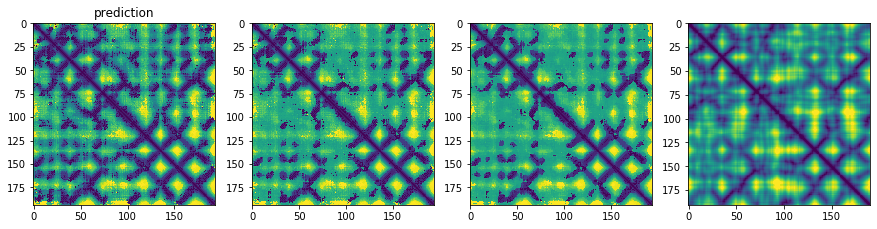

In [243]:
fig, (ax1, ax2, ax4, ax3) = plt.subplots(1, 4,figsize=(15,5))    
ax1.imshow(np.argmax(p.dist['distogram'],axis=0))
ax1.set_title('prediction')
ax2.imshow(np.argmax(fada,axis=0))
residues = p.native.total_residue()
dist = np.zeros((residues,residues))
for i, j in product(range(1,residues+1),range(1,residues+1)):
    dist[i-1,j-1] = (xyz(p.native,i) - xyz(p.native,j)).norm()
ax3.imshow(dist.clip(4,42.5))
ax4.imshow(np.argmax(gf(fada, 0.5),axis=0))

In [189]:
# function to be used for reduction
prob_smaller = 0.8
prob_correct = 0.8
sulfo_smaller = 23
# do the plots agree?
def f(angstrom):
    return 1 - 1.0 / (1 + np.exp(-angstrom  + sulfo_smaller)) #/ 20 + (a - sulfo_smaller)))

0.7958047950551616


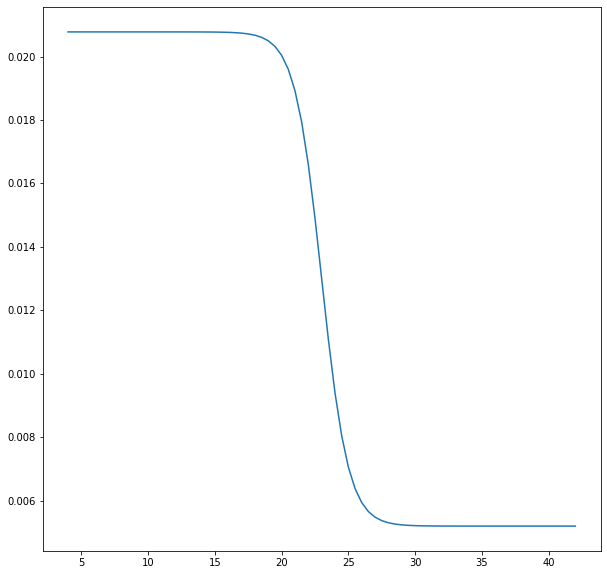

In [219]:
bins = np.arange(4,42.5,0.5)
prob_sulfo = 0.8
probs = f(bins)*(2*prob_sulfo-1)+(1-prob_sulfo)
probs = probs / probs.sum()

plt.plot(bins,probs)
print(probs[:40].sum())

### [Question] Why are more distances predicted than there are in the native?

In [109]:
p = Protein(dirname, protein_names[1])
residues = p.dist['distogram'].shape[1]
print("Residues in \n dist: %s \n native: %s " % (residues,p.native.total_residue()) )

Residues in 
 dist: 194 
 native: 191 


- rather than propergate and extrapolate (instead of kde use a custom function)
- adapt kernel width to the protein based on the matrix

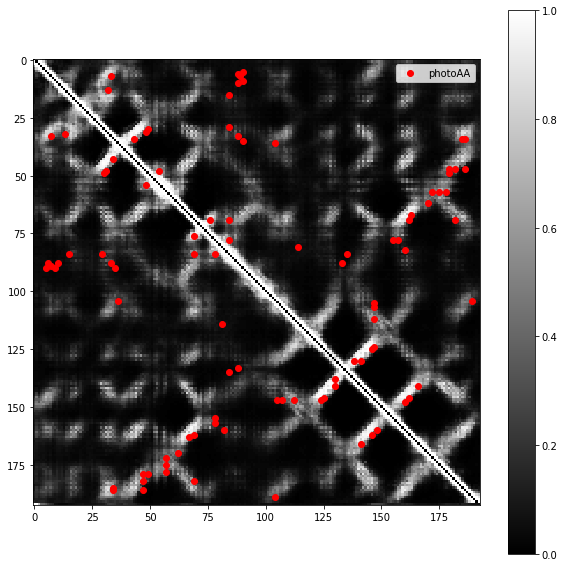

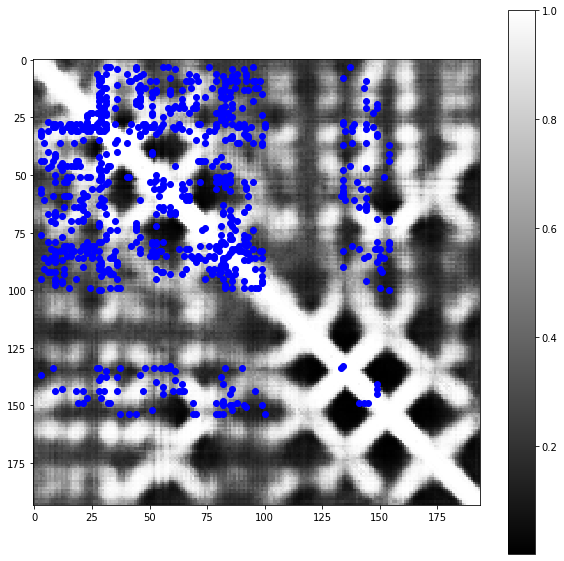

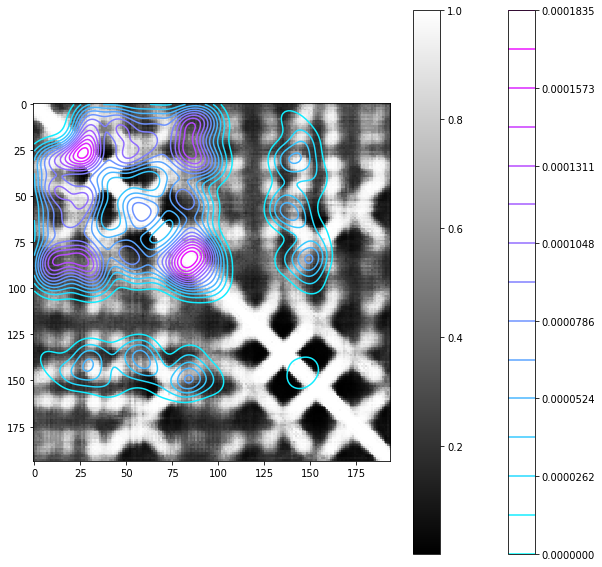

In [8]:
p = Protein(dirname, protein_names[1])
show_matrix(p)
plt.show()
show_dist(p,density=False)
plt.show()
show_dist(p,density=True)

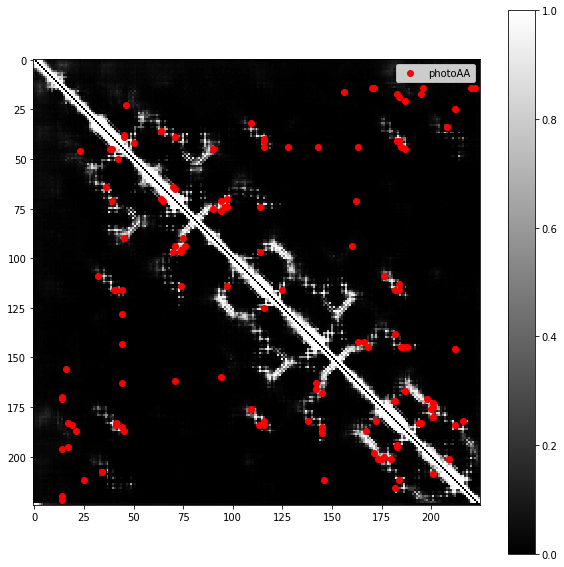

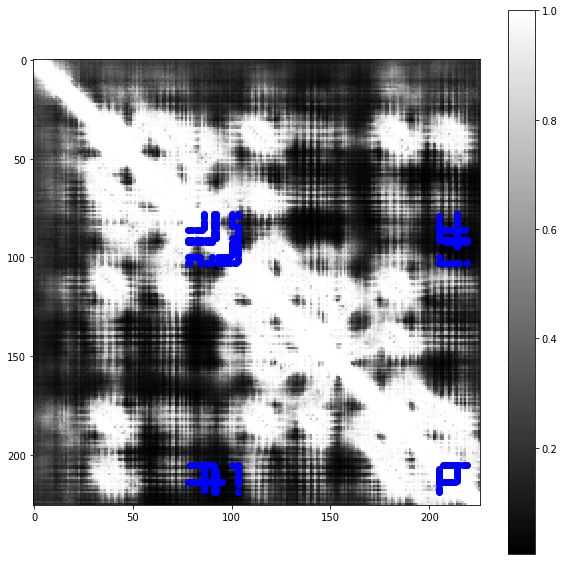

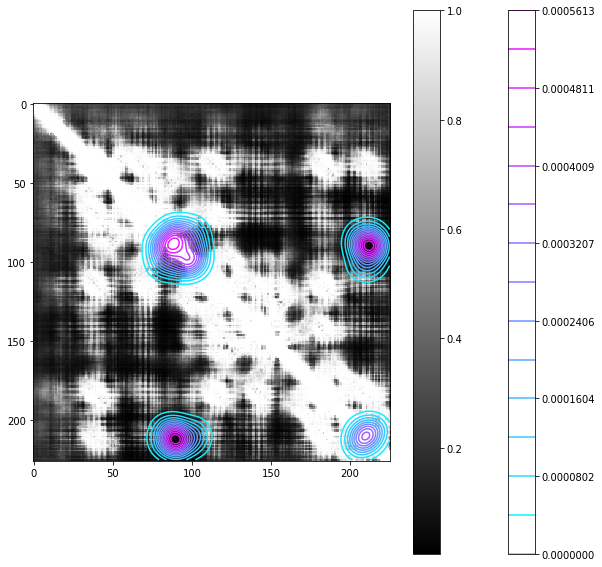

In [9]:
p = Protein(dirname, protein_names[2])
show_matrix(p)
plt.show()
show_dist(p,density=False)
plt.show()
show_dist(p,density=True)

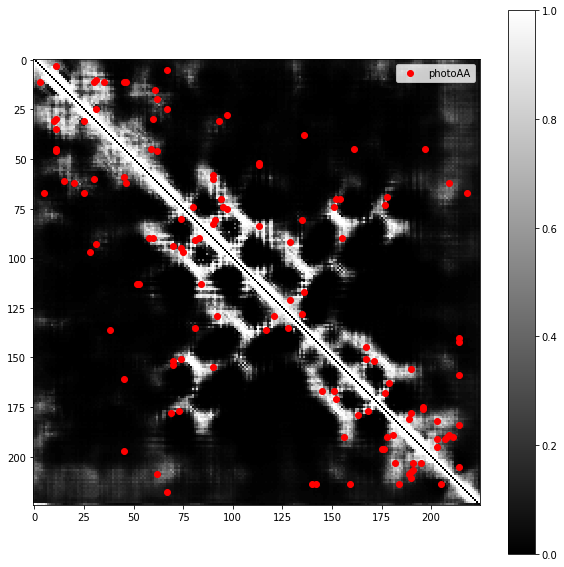

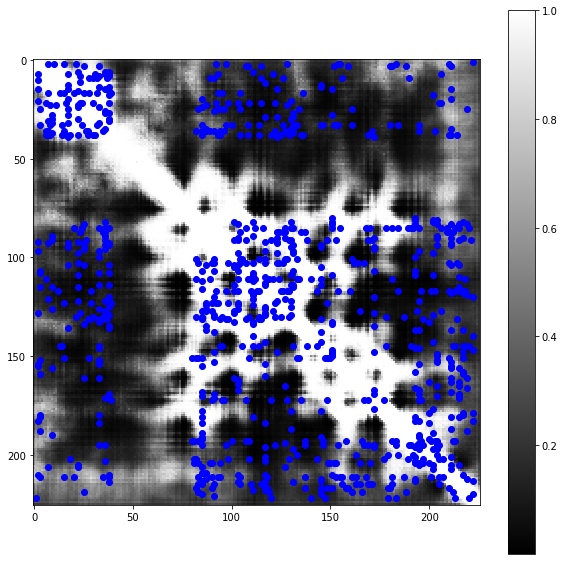

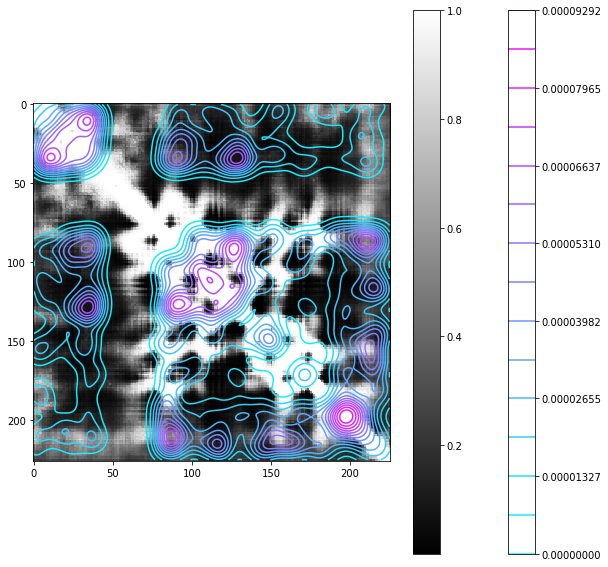

In [10]:
p = Protein(dirname, protein_names[3])
show_matrix(p)
plt.show()
show_dist(p,density=False)
plt.show()
show_dist(p,density=True)

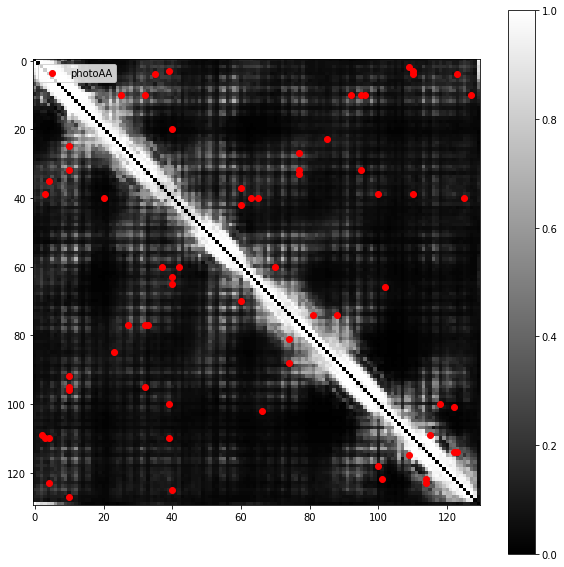

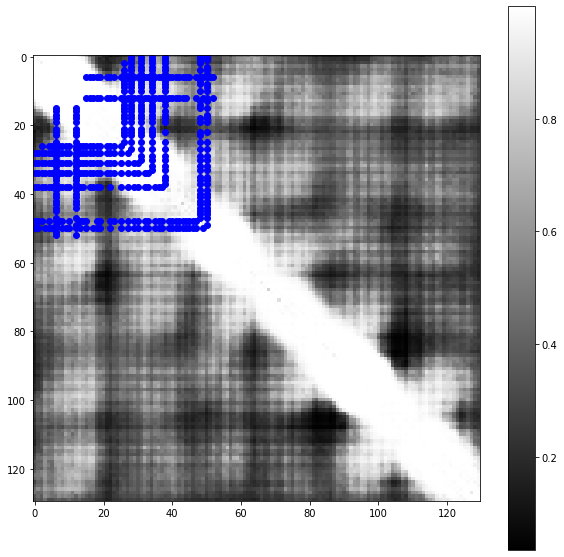

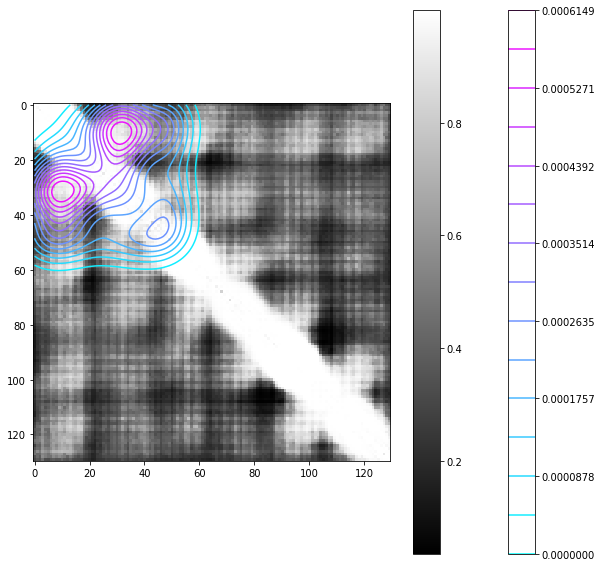

In [11]:
p = Protein(dirname, protein_names[4])
show_matrix(p)
plt.show()
show_dist(p,density=False)
plt.show()
show_dist(p,density=True)

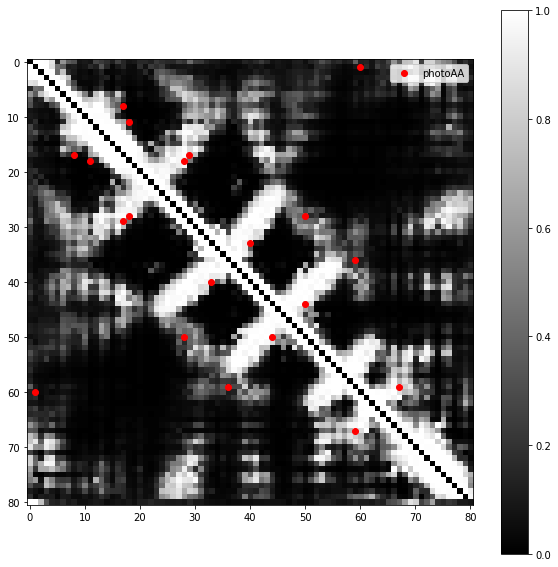

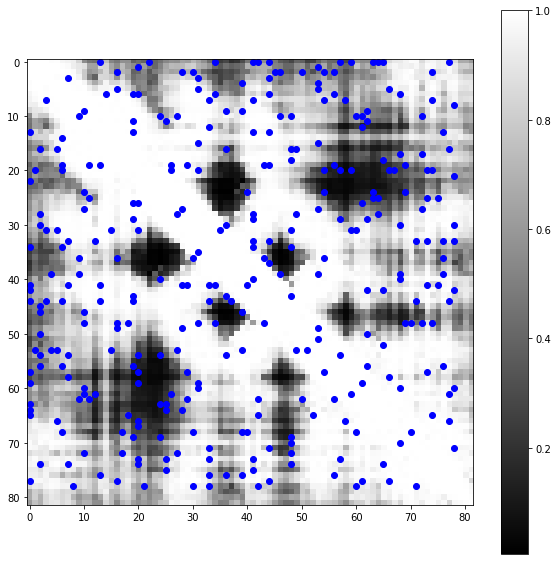

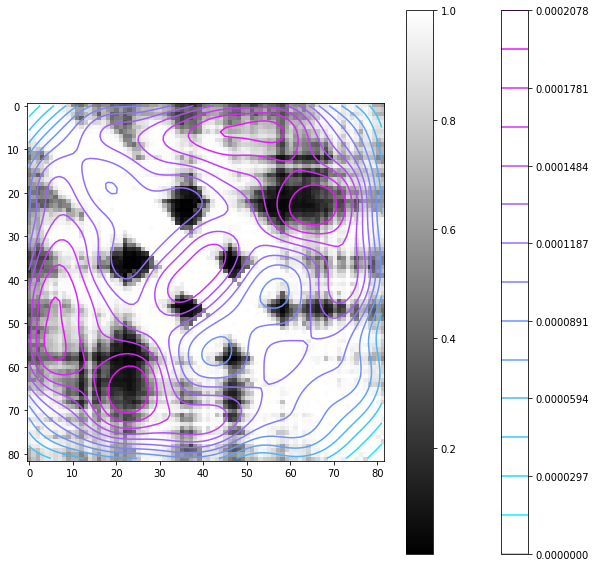

In [12]:
p = Protein(dirname, protein_names[5])
show_matrix(p)
plt.show()
show_dist(p,density=False)
plt.show()
show_dist(p,density=True)

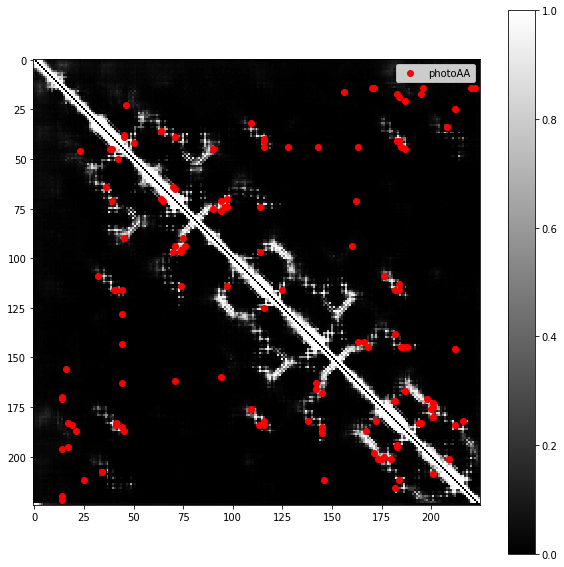

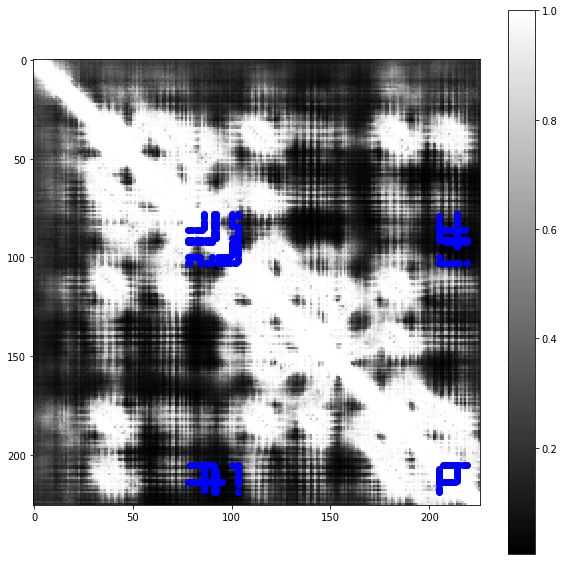

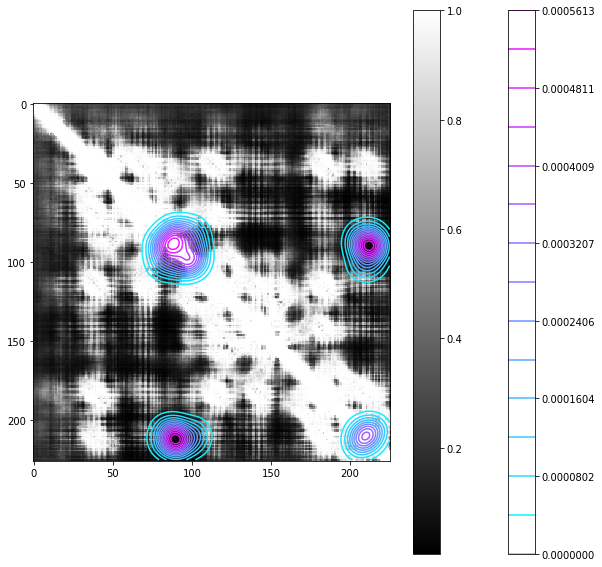

In [13]:
p = Protein(dirname, protein_names[2])
show_matrix(p)
plt.show()
show_dist(p,density=False)
plt.show()
show_dist(p,density=True)

In [6]:
p = Protein(dirname, protein_names[1])
list(p.dist.keys())

['distogram', 'ss', 'phi', 'phi_kappa', 'psi', 'psi_kappa']

In [7]:
(23-4)/0.5

38.0

In [8]:
p.dist['distogram'][:38,:,:].sum(axis=0)

array([[1.        , 0.99998194, 0.99990577, ..., 0.2858174 , 0.29552573,
        0.27981764],
       [0.99998194, 0.9999985 , 0.999989  , ..., 0.35715497, 0.443023  ,
        0.31093803],
       [0.99990577, 0.999989  , 1.0000002 , ..., 0.41175893, 0.4037525 ,
        0.37017402],
       ...,
       [0.2858174 , 0.35715497, 0.41175893, ..., 1.0000005 , 0.9999709 ,
        0.9998502 ],
       [0.29552573, 0.443023  , 0.4037525 , ..., 0.9999709 , 1.        ,
        0.9998362 ],
       [0.27981764, 0.31093803, 0.37017402, ..., 0.9998502 , 0.9998362 ,
        1.        ]], dtype=float32)

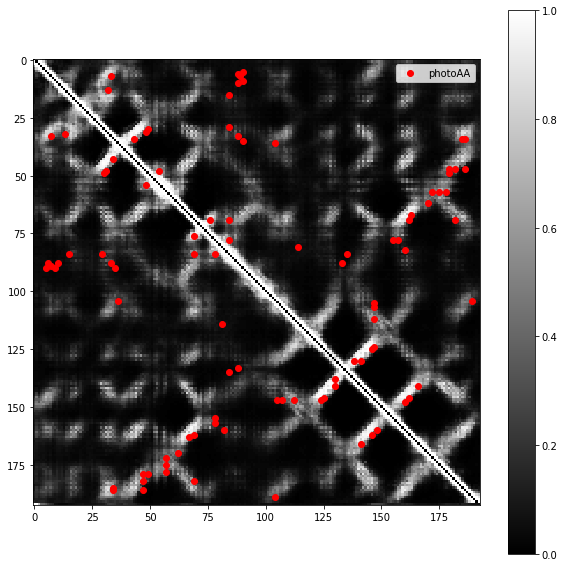

In [9]:
show_matrix(Protein(dirname, protein_names[1]))

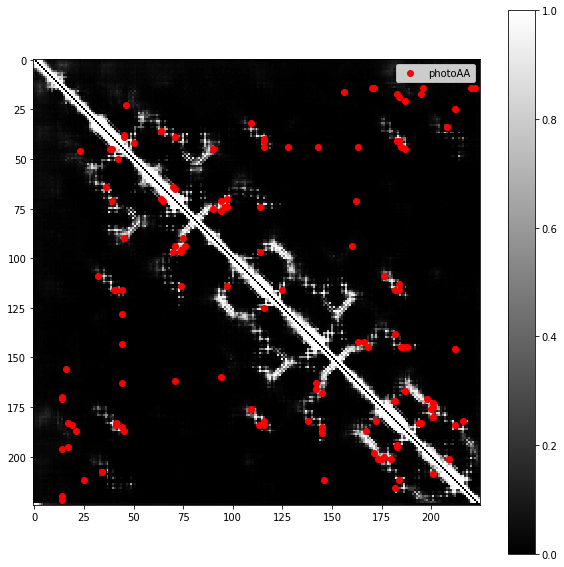

In [10]:
show_matrix(Protein(dirname, protein_names[2]))